<a href="https://colab.research.google.com/github/ampereapescador/MetodosI_AnaPerea_JuanGomez/blob/main/MinimosCuadrados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
from scipy.stats import poisson, norm
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#!pip install emcee
#!pip install corner
import emcee
import corner
import csv
import requests

1.
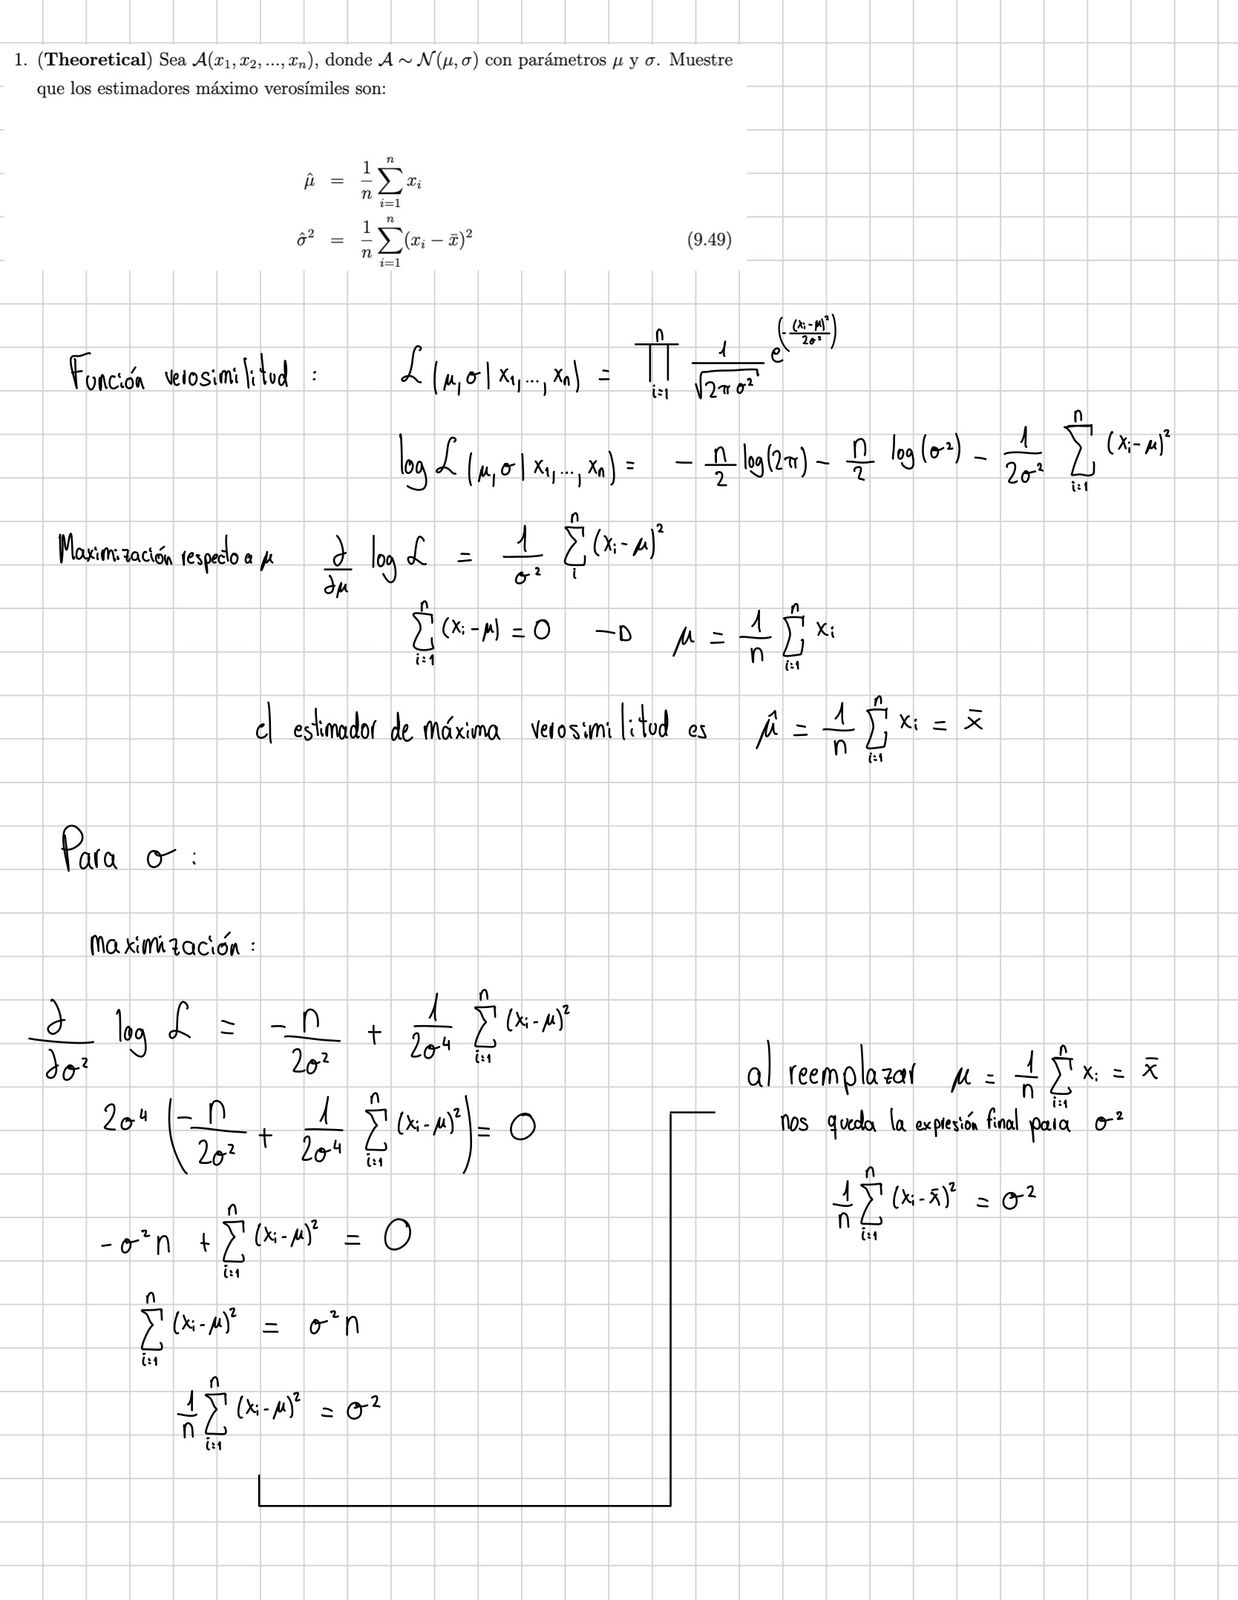

2. 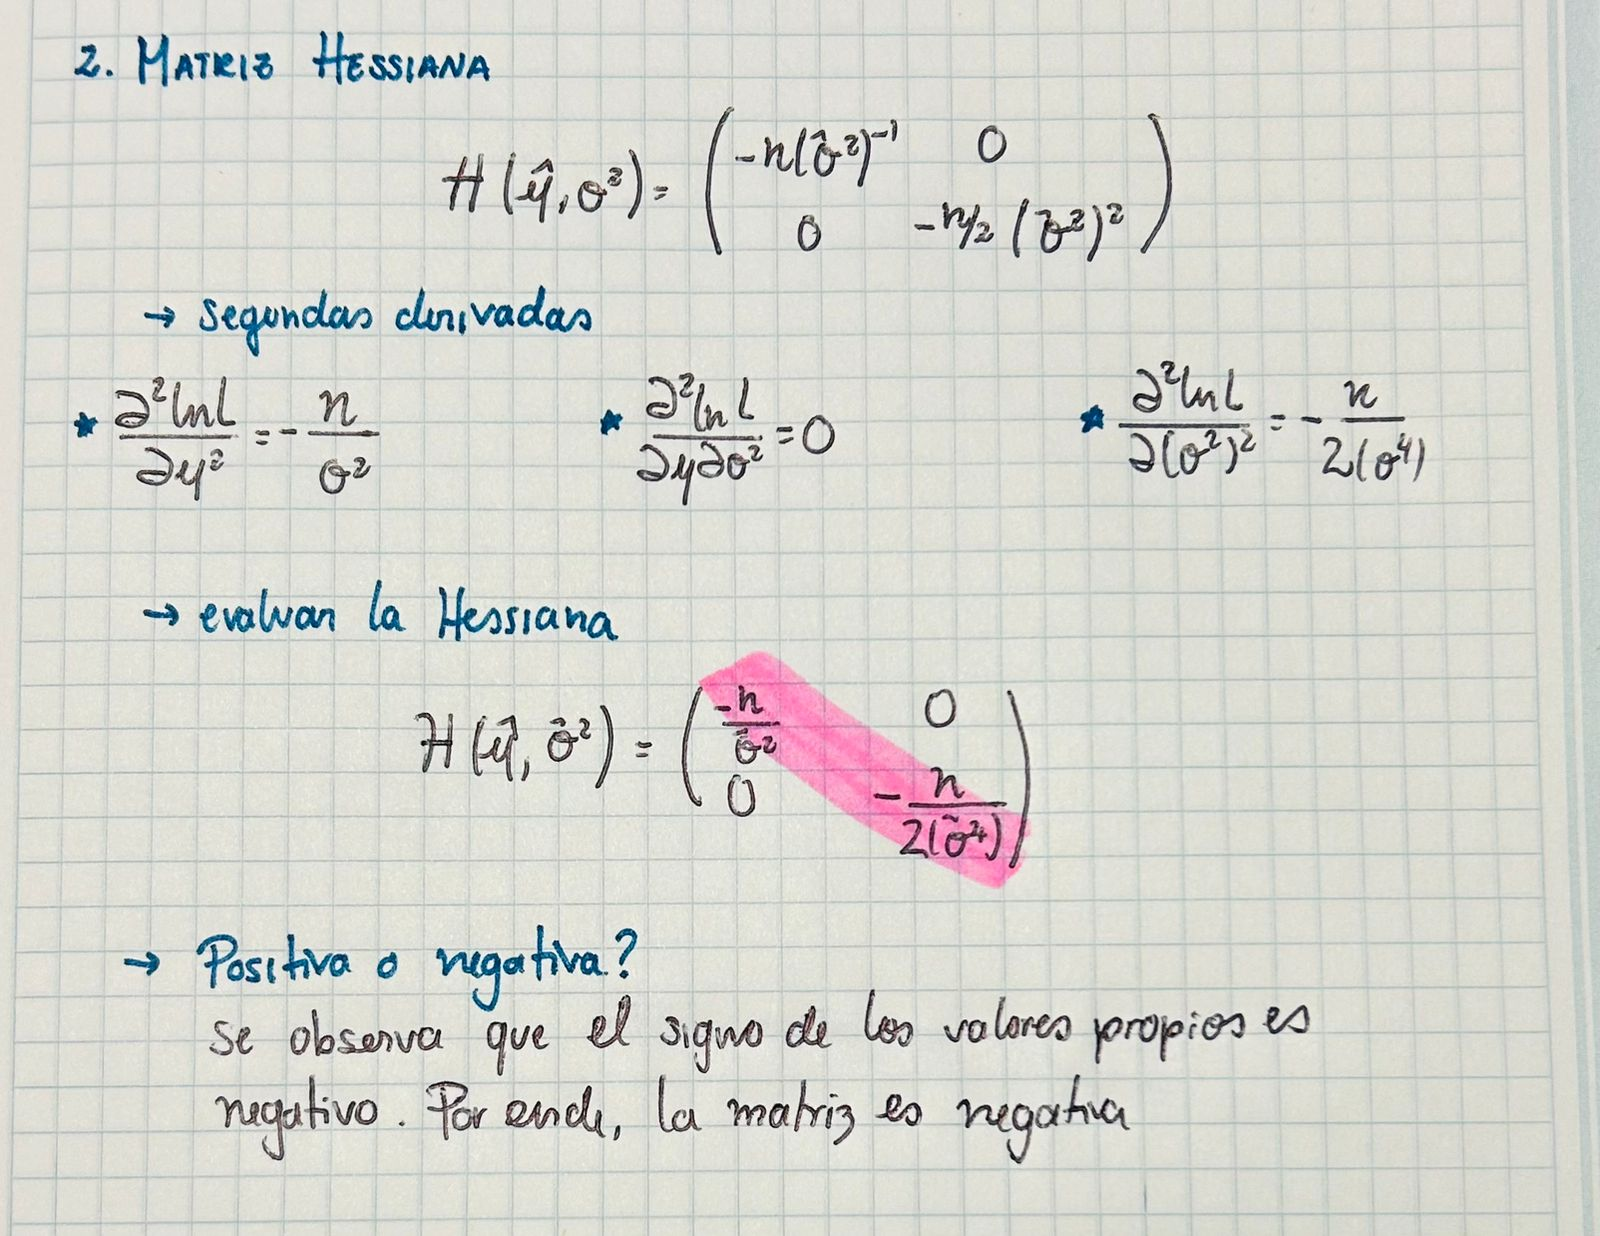

Estimación de mu: 4.7383207600066
Estimación de sigma: 1.410501693449928


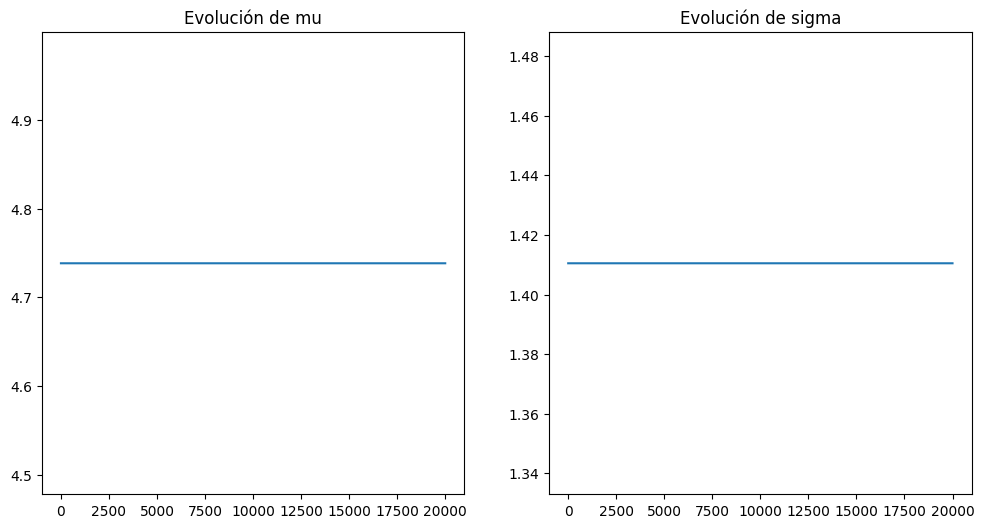

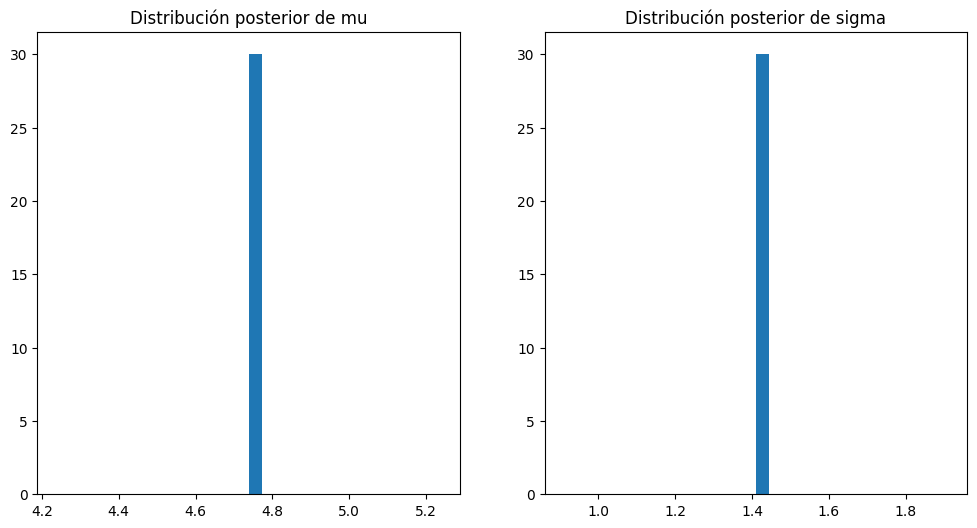

In [14]:
#3
#Datos cargados
datos = np.genfromtxt('Gaussiano.csv', delimiter='.',skip_header=1)

#Liikelihood Gaussiana
def likelihood(mu, sigma, data):
    N = len(data)
    return np.prod((1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(data - mu)**2 / (2 * sigma**2)))

#función de probabilidad a priori
def prior(mu, sigma):
    if 3 <= mu <= 5 and 0.5 <= sigma <= 3.5:
        return 1
    return 0

#Logaritmo de la distribución posterior
def log_posterior(mu, sigma, data):
    L = likelihood(mu, sigma, data)
    prior_prob = prior(mu, sigma)
    if L == 0 or prior_prob == 0:
        return -np.inf  # Evitar log(0)
    return np.log(L) + np.log(prior_prob)

#Metropolis-Hastings
def metropolis_hastings(data, N=20000):

    mu_current = np.random.uniform(3, 5)
    sigma_current = np.random.uniform(0.5, 3.5)

    mu_values = [mu_current]
    sigma_values = [sigma_current]

    for i in range(N):
        mu_proposal = np.random.normal(mu_current, 0.1)
        sigma_proposal = np.random.normal(sigma_current, 0.1)

        #Sigma positivo
        if sigma_proposal <= 0:
            sigma_proposal = sigma_current

        # Calculo log-posterior para el estado actual y  propuesta
        log_post_current = log_posterior(mu_current, sigma_current, data)
        log_post_proposal = log_posterior(mu_proposal, sigma_proposal, data)

        #Aceptacion de rata
        acceptance_ratio = np.exp(log_post_proposal - log_post_current)
        if np.random.rand() < acceptance_ratio:
            mu_current = mu_proposal
            sigma_current = sigma_proposal
        mu_values.append(mu_current)
        sigma_values.append(sigma_current)

    return np.array(mu_values), np.array(sigma_values)

#Metropolis-Hastings
mu_samples, sigma_samples = metropolis_hastings(datos)

#Parámetros (media de las muestras)
mu_estimate = np.mean(mu_samples)
sigma_estimate = np.mean(sigma_samples)


print(f"Estimación de mu: {mu_estimate}")
print(f"Estimación de sigma: {sigma_estimate}")

#IMPRIMIR cadenas de Markov
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mu_samples)
plt.title("Evolución de mu")
plt.subplot(1, 2, 2)
plt.plot(sigma_samples)
plt.title("Evolución de sigma")
plt.show()

#Histograma de las distribuciones obtenidas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, density=True)
plt.title("Distribución posterior de mu")
plt.subplot(1, 2, 2)
plt.hist(sigma_samples, bins=30, density=True)
plt.title("Distribución posterior de sigma")
plt.show()


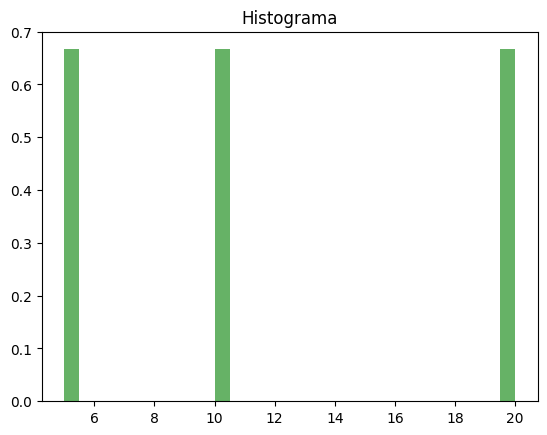

 84%|████████▍ | 16776/20000 [00:27<00:07, 418.24it/s]

In [ ]:
#4

#Datos cargados
datos = np.genfromtxt('Gaussiano.csv', delimiter='.',skip_header=1)

#Imprimir datos
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histograma')
plt.show()

#Likelihood Gaussiana
def log_likelihood(params, data):
    mu, sigma = params
    if sigma <= 0:
        return -np.inf  #sigma  positivo
    return -0.5 * np.sum(((data - mu) / sigma)**2 + np.log(2 * np.pi * sigma**2))

#Distribución a priori uniforme
def log_prior(params):
    mu, sigma = params
    if 3 <= mu <= 5 and 0.5 <= sigma <= 3.5:
        return 0.0
    return -np.inf  #Negativo fuera de los límites

#Distribución posterior
def log_posterior(params, data):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, data)

#Metropolis-Hastings con emcee
n_walkers = 50  # walkers
n_dim = 2  # Dimensiones
n_steps = 20000

# Inicializar valores iniciales segun rango de mu
np.random.seed(42)
initial_guess = np.random.rand(n_walkers, n_dim)
initial_guess[:, 0] = initial_guess[:, 0] * 2 + 3
initial_guess[:, 1] = initial_guess[:, 1] * 3 + 0.5

# Configurar del sampler de emcee
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=[data])
sampler.run_mcmc(initial_guess, n_steps, progress=True)
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Impresion  distribución de los parámetros mu y sigma
fig = corner.corner(samples, labels=["mu", "sigma"], truths=[4, 1])

mu_mcmc, sigma_mcmc = np.percentile(samples[:, 0], [16, 50, 84]), np.percentile(samples[:, 1], [16, 50, 84])
mu_best, mu_minus, mu_plus = mu_mcmc[1], mu_mcmc[1]-mu_mcmc[0], mu_mcmc[2]-mu_mcmc[1]
sigma_best, sigma_minus, sigma_plus = sigma_mcmc[1], sigma_mcmc[1]-sigma_mcmc[0], sigma_mcmc[2]-sigma_mcmc[1]

print(f"Mejor estimación para mu: {mu_best:.2f} +{mu_plus:.2f} -{mu_minus:.2f}")
print(f"Mejor estimación para sigma: {sigma_best:.2f} +{sigma_plus:.2f} -{sigma_minus:.2f}")


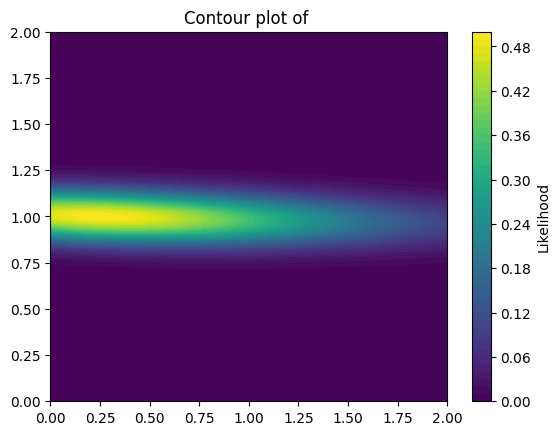

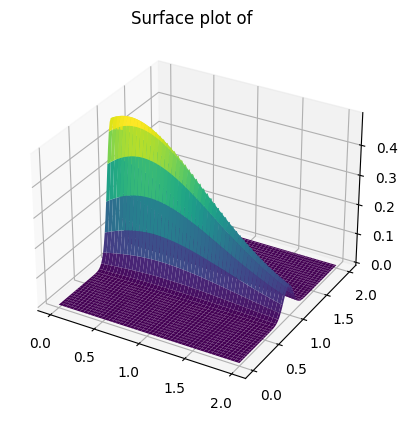

In [13]:
#6
#Parámetros
n = 10  #eventos
b = 9   #física conocida
s = 4   #nueva física
epsilon_bar = 1  #eficiencia media
sigma = 0.1  #Desviación estándar de epsilon

#Definicion Likelihood
def likelihood(mu, epsilon):

    poisson_term = poisson.pmf(n, mu * s + epsilon * b) #Poisson
    gauss_term = norm.pdf(epsilon, loc=epsilon_bar, scale=sigma) # Gaussiana
    return poisson_term * gauss_term

# Rango de valores para mu y epsilon
mu_vals = np.linspace(0, 2, 100)
epsilon_vals = np.linspace(0, 2, 100)

# Crear una grilla
MU, EPSILON = np.meshgrid(mu_vals, epsilon_vals)
L = likelihood(MU, EPSILON)

# Graficar el contorno con curvas de nivel
plt.contourf(MU, EPSILON, L, levels=50, cmap='viridis')
plt.colorbar(label='Likelihood')
plt.xlabel(r'')
plt.ylabel(r'')
plt.title(r'Contour plot of ')
plt.show()

# Graficar la superficie 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(MU, EPSILON, L, cmap='viridis')
ax.set_xlabel(r'')
ax.set_ylabel(r'')
ax.set_zlabel(r'')
plt.title(r'Surface plot of ')
plt.show()



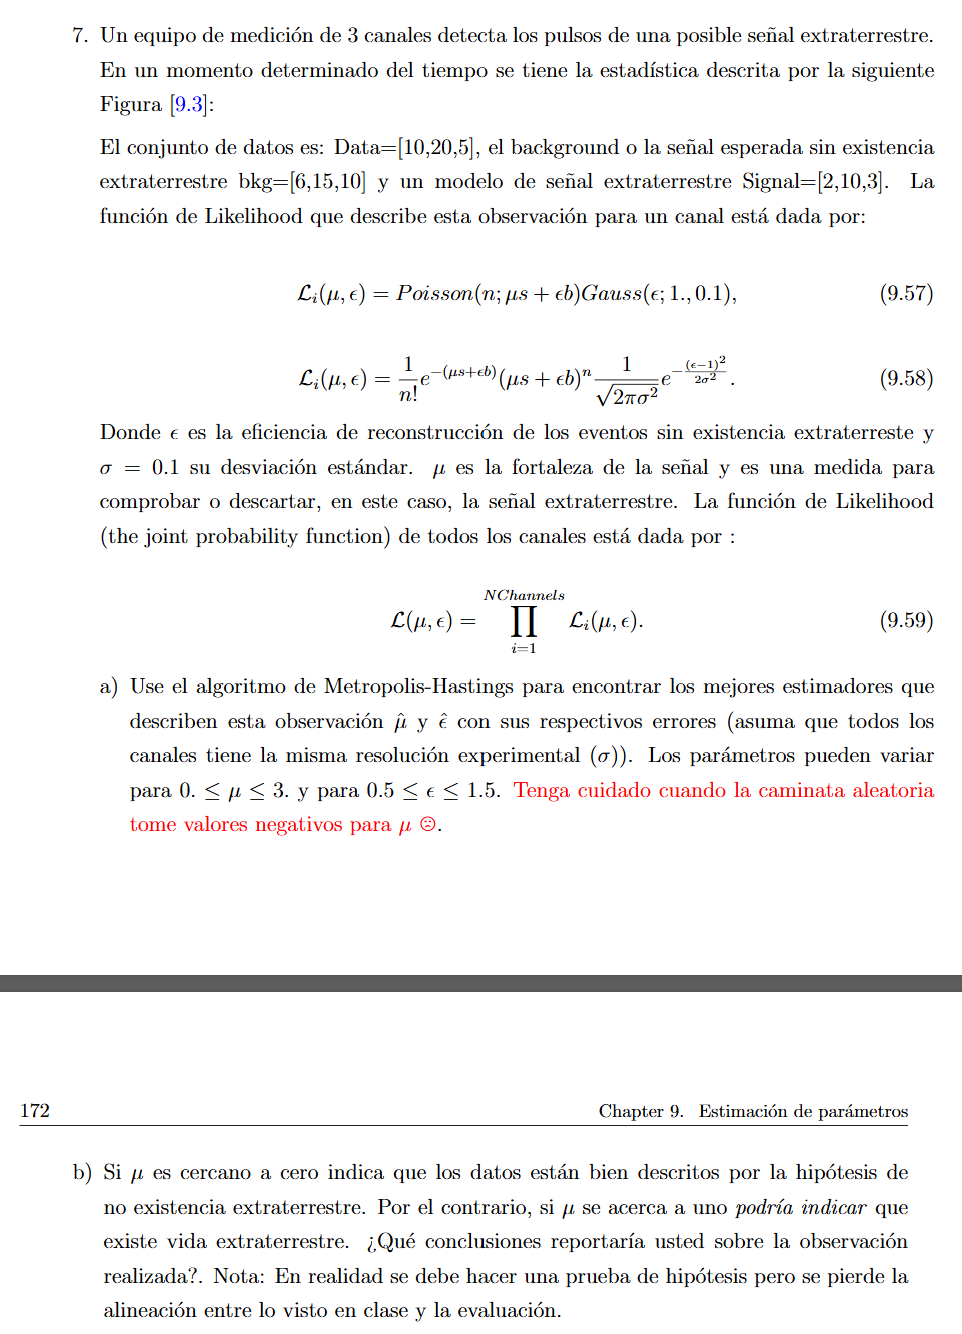

Tasa de aceptación: 0.5278


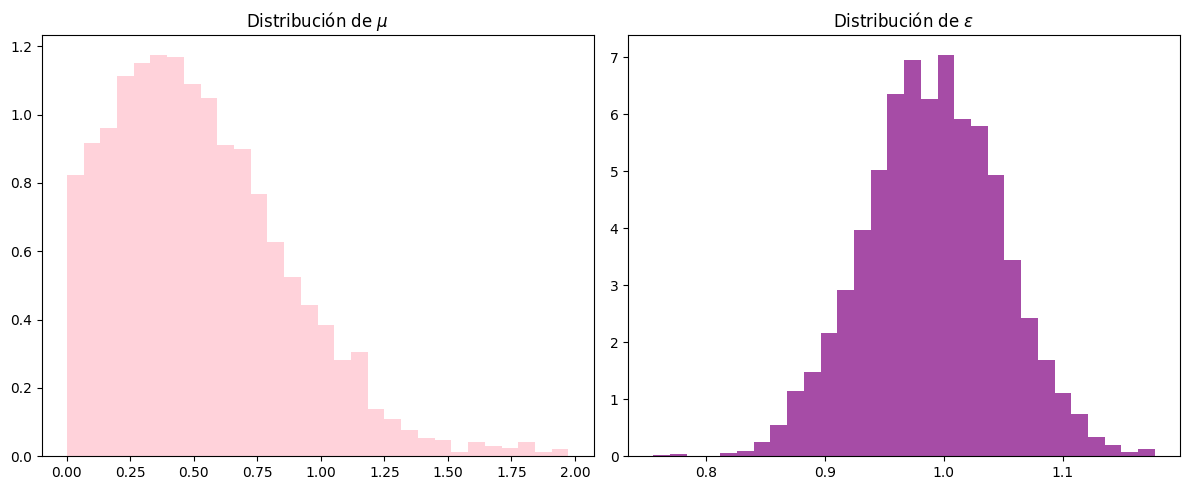

In [4]:
#7

#Conjunto de datos
data = np.array([10, 20, 5])
bkg = np.array([6, 15, 10])
signal = np.array([2, 10, 3])


sigma = 0.1

#Likelihood
def likelihood_channel(mu, epsilon, n, s, b):
    poisson_term = poisson.pmf(n, mu * s + epsilon * b)
    gaussian_term = norm.pdf(epsilon, loc=1, scale=sigma)
    return poisson_term * gaussian_term

#Likelihood para todos los canales
def joint_likelihood(mu, epsilon, data, signal, bkg):
    L = 1.0
    for i in range(len(data)):
        L *= likelihood_channel(mu, epsilon, data[i], signal[i], bkg[i])
    return L

#Metropolis-Hastings
def metropolis_hastings(data, signal, bkg, n_iter=10000, mu_init=1.0, epsilon_init=1.0):
    mu_current = mu_init
    epsilon_current = epsilon_init
    samples = []
    acceptance = 0

    for i in range(n_iter):
        #Caminata aleatoria
        mu_proposal = np.abs(mu_current + np.random.normal(0, 0.1))
        epsilon_proposal = epsilon_current + np.random.normal(0, 0.1)

        #Limites epsilon
        if epsilon_proposal < 0.5 or epsilon_proposal > 1.5:
            epsilon_proposal = epsilon_current

        #Rata aceptación
        likelihood_current = joint_likelihood(mu_current, epsilon_current, data, signal, bkg)
        likelihood_proposal = joint_likelihood(mu_proposal, epsilon_proposal, data, signal, bkg)
        acceptance_ratio = likelihood_proposal / likelihood_current


        if np.random.rand() < acceptance_ratio:
            mu_current = mu_proposal
            epsilon_current = epsilon_proposal
            acceptance += 1

        #Muestras
        samples.append([mu_current, epsilon_current])

    acceptance_rate = acceptance / n_iter
    print(f"Tasa de aceptación: {acceptance_rate}")
    return np.array(samples)

#Algoritmo Metropolis-Hastings
samples = metropolis_hastings(data, signal, bkg)

# Graficar los resultados
mu_samples = samples[:, 0]
epsilon_samples = samples[:, 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, density=True, color='pink', alpha=0.7)
plt.title(r'Distribución de $\mu$')

plt.subplot(1, 2, 2)
plt.hist(epsilon_samples, bins=30, density=True, color='purple', alpha=0.7)
plt.title(r'Distribución de $\epsilon$')

plt.tight_layout()
plt.show()
